In [1]:
# import necessary packages
import sys
import numpy as np
import matplotlib as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import scipy as sp
import osmnx as ox
import networkx as nx

In [2]:
# Laden der Standorte aus CSV-Datei
file_sensor_locations = './Sensorstandorte.csv'

sensor_location_df =  pd.read_csv(file_sensor_locations,delimiter=';',decimal=',')

# Plot Header
print(sensor_location_df.keys())

Index(['gid', 'aktiv', 'objectid', 'gisid', 'guid', 'alknummer', 'arglr',
       'baumnummer', 'datlr', 'gattung', 'gattungart', 'ga_lang', 'gebiet',
       'hrherkunft', 'namlr', 'pflanzjahr', 'standort', 'strasse', 'baumhoehe',
       'st_durchm', 'st_umfang', 'kr_durchm', 'vitalitaet', 'objektkuerzel',
       'pflegebereich', 'tour', 'faellung', 'gefaellt_am', 'faellgrund',
       'historisch_am', 'hochwert', 'rechtswert', 'the_geom', 'geom_original',
       'geom_4326', 'geom_4326_json', 'geom_4326_json_bbox', 'lon_4326',
       'lat_4326'],
      dtype='object')


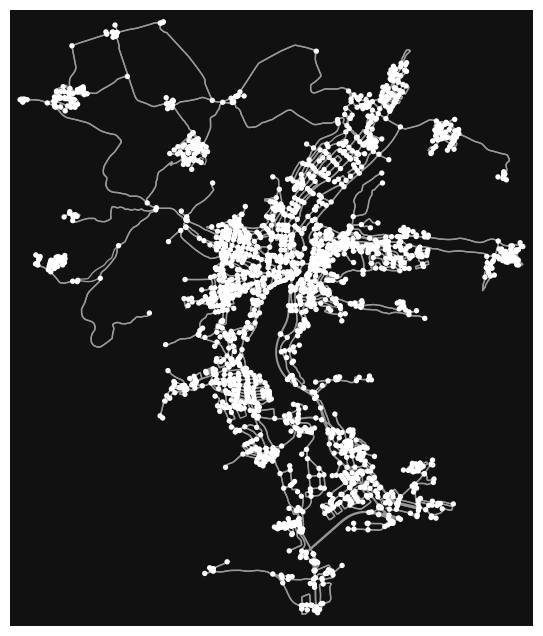

In [3]:
## download/model a street network for some city then visualize it
G = ox.graph_from_place('Jena, Germany', network_type="drive")
fig, ax = ox.plot_graph(G)

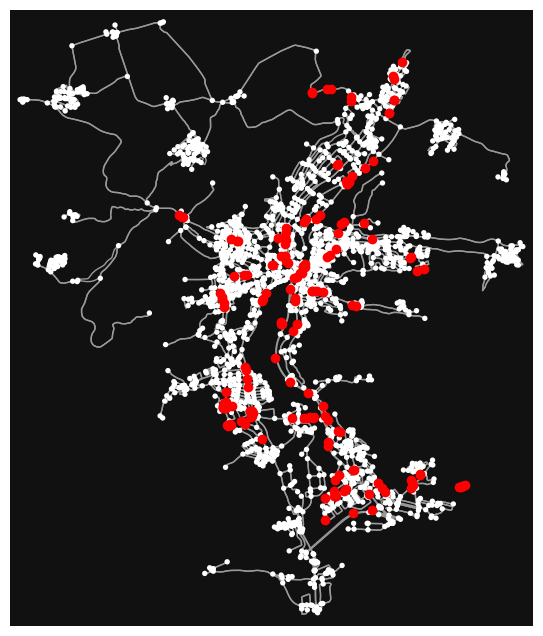

In [4]:
# Hinzufügen der Gießstellen
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.scatter( sensor_location_df["lon_4326"], sensor_location_df["lat_4326"], c='red')

In [5]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [6]:
# Punkte, die wir zum Test abfahren und bewässern wollen:
# ID 1 ist der Startpunkt
relevant_points_ids = [0,5,10,20,57,99,103]

# da wir zum Start zurück fahren, fügen wir den ersten Punkt an das Ende der Tour
#relevant_points_ids.append (relevant_points_ids[0])

# ZIEL: Wir testen alle Permutationen (Reihenfolgen von IDs)
import itertools
all_permutations = list(itertools.permutations(relevant_points_ids))
print(all_permutations)

[(0, 5, 10, 20, 57, 99, 103), (0, 5, 10, 20, 57, 103, 99), (0, 5, 10, 20, 99, 57, 103), (0, 5, 10, 20, 99, 103, 57), (0, 5, 10, 20, 103, 57, 99), (0, 5, 10, 20, 103, 99, 57), (0, 5, 10, 57, 20, 99, 103), (0, 5, 10, 57, 20, 103, 99), (0, 5, 10, 57, 99, 20, 103), (0, 5, 10, 57, 99, 103, 20), (0, 5, 10, 57, 103, 20, 99), (0, 5, 10, 57, 103, 99, 20), (0, 5, 10, 99, 20, 57, 103), (0, 5, 10, 99, 20, 103, 57), (0, 5, 10, 99, 57, 20, 103), (0, 5, 10, 99, 57, 103, 20), (0, 5, 10, 99, 103, 20, 57), (0, 5, 10, 99, 103, 57, 20), (0, 5, 10, 103, 20, 57, 99), (0, 5, 10, 103, 20, 99, 57), (0, 5, 10, 103, 57, 20, 99), (0, 5, 10, 103, 57, 99, 20), (0, 5, 10, 103, 99, 20, 57), (0, 5, 10, 103, 99, 57, 20), (0, 5, 20, 10, 57, 99, 103), (0, 5, 20, 10, 57, 103, 99), (0, 5, 20, 10, 99, 57, 103), (0, 5, 20, 10, 99, 103, 57), (0, 5, 20, 10, 103, 57, 99), (0, 5, 20, 10, 103, 99, 57), (0, 5, 20, 57, 10, 99, 103), (0, 5, 20, 57, 10, 103, 99), (0, 5, 20, 57, 99, 10, 103), (0, 5, 20, 57, 99, 103, 10), (0, 5, 20, 57

In [7]:

shortest_permutation = -1
shortest_distance = 999999999999999

for permutation_idx, _ in enumerate(all_permutations):
    #print( str(perutation_idx) + ' : ' + str(list(all_permutations[permutation_idx])))
    
    # Permutation mit den point_IDs der jeweiligen Gießstelle
    permutation = list(all_permutations[permutation_idx])
    
    if(all_permutations[permutation_idx][0] != 0):
        continue
    
    summarized_route_length = 0
    
    # Berechnen der Einzelpfade von Gießstelle zu Gießstelle 
    for path_idx, _ in enumerate(permutation):
        #print(permutation[path_idx])
    
        if path_idx < len(permutation) - 1:
            p1 = permutation[path_idx]
            p2 = permutation[path_idx+1]
        else:
            p1 = permutation[path_idx]
            p2 = permutation[0]

        # get the nearest network nodes to two lat/lng points with the distance module
        orig = ox.distance.nearest_nodes(G, X=sensor_location_df["lon_4326"][p1], Y=sensor_location_df["lat_4326"][p1])
        dest = ox.distance.nearest_nodes(G, X=sensor_location_df["lon_4326"][p2], Y=sensor_location_df["lat_4326"][p2])

        # find the shortest path between nodes, minimizing travel time, then plot it
        route = ox.shortest_path(G, orig, dest, weight="travel_time")
        edge_lengths = ox.utils_graph.route_to_gdf(G, route)["length"]
        
        edge_lengths = round(sum(edge_lengths))
        summarized_route_length = summarized_route_length + edge_lengths
        
    #print(str(permutation_idx) + '\t: ' + str(summarized_route_length))
    if summarized_route_length < shortest_distance:
        shortest_distance = summarized_route_length
        shortest_permutation = permutation
        
print("Shortest Distance: " + str(shortest_distance))
print(shortest_permutation)

Shortest Distance: 24886
[0, 99, 20, 10, 57, 103, 5]


0 --> 99 :	7482	red
99 --> 20 :	3584	orange
20 --> 10 :	6702	yellow
10 --> 57 :	858	green
57 --> 103 :	2282	blue
103 --> 5 :	2592	purple
5 --> 0 :	1386	red


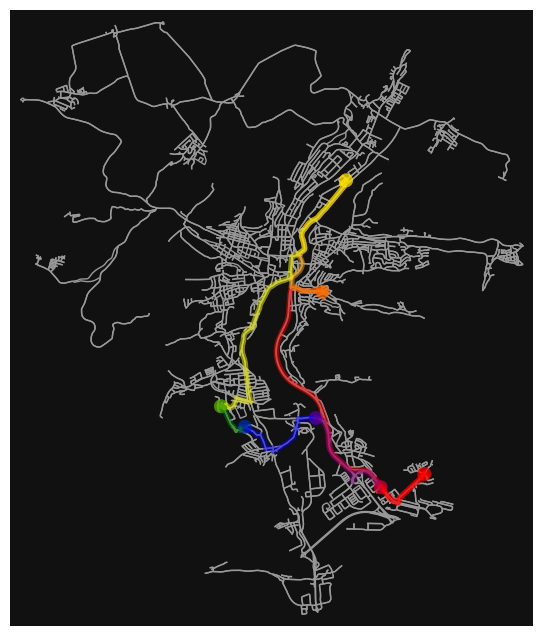

In [9]:
# Visualisieren der Strecke
routes = []
colors = ['red','orange','yellow','green','blue','purple','red']

for point_idx, point_id in enumerate(shortest_permutation):
    if point_idx < len(shortest_permutation) - 1:
        p1 = shortest_permutation[point_idx]
        p2 = shortest_permutation[point_idx+1]
    else:
        p1 = shortest_permutation[point_idx]
        p2 = shortest_permutation[0]

    # get the nearest network nodes to two lat/lng points with the distance module
    orig = ox.distance.nearest_nodes(G, X=sensor_location_df["lon_4326"][p1], Y=sensor_location_df["lat_4326"][p1])
    dest = ox.distance.nearest_nodes(G, X=sensor_location_df["lon_4326"][p2], Y=sensor_location_df["lat_4326"][p2])

    # find the shortest path between nodes, minimizing travel time, then plot it
    route = ox.shortest_path(G, orig, dest, weight="travel_time")
    edge_lengths = ox.utils_graph.route_to_gdf(G, route)["length"]
    edge_lengths = round(sum(edge_lengths))

    print(str(p1) + ' --> ' + str(p2) + ' :\t' + str(edge_lengths) + '\t' + colors[point_idx])

    
    routes.append(route)

fig, ax = ox.plot_graph_routes(G, routes, route_colors=colors,  route_linewidth=6,  node_size=0)